# Table of content
1. [Importing relevent libraries](#01)
2. [Loading Dataset](#02)
3. [Distributions](#03)
    - [Age Distribution](#3.1)
    - [Ethnicity Distribution](#3.2)
    - [Gender Distribution](#3.3)
    - [Gender Distribution](#3.3)
    - [Sample Images](#3.4)
4. [Model for Gender Prediction](#04)
    - [Spliting data into train/test](#4.1)
    - [Build and train model](#4.2)
    - [Evaluating training history](#4.3)
5. [Model for Ethnicity Prediction](#05)
    - [Spliting data into train/test](#5.1)
    - [Build and train model](#5.2)
    - [Evaluating training history](#5.3)
6. [Model for Age Prediction](#06)
    - [Spliting data into train/test](#6.1)
    - [Build and train model](#6.2)
    - [Evaluating training history](#6.3)

## Importing relevent libraries <a id="01"></a>

In [7]:
# Đọc nhãn từ CSV và chuẩn bị cho việc load ảnh trực tiếp
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

print("📖 Đang tải metadata...")

# Tìm file CSV chứa nhãn
possible_csv_paths = [
    'age_gender_labels_only_FINAL_CLEANED.csv',        # File CSV mới
    'age_gender.csv',                                   # File CSV cũ
    'data/age_gender.csv',                             # Thư mục data
]

# Tìm thư mục chứa hình ảnh
possible_image_dirs = [
    'data',           # Thư mục data
    'images',         # Thư mục images
    '.',              # Thư mục hiện tại
]

# Tìm file CSV
csv_file = None
for path in possible_csv_paths:
    if os.path.exists(path):
        csv_file = path
        print(f"✅ Tìm thấy file CSV: {path}")
        break
        
if csv_file is None:
    print("❌ Không tìm thấy file CSV!")
    raise FileNotFoundError("Không tìm thấy file CSV chứa nhãn")

# Tìm thư mục chứa hình ảnh  
image_dir = None
for path in possible_image_dirs:
    if os.path.exists(path) and any(f.endswith('.jpg') for f in os.listdir(path)):
        image_dir = path
        print(f"✅ Tìm thấy thư mục hình ảnh: {path}")
        break
        
if image_dir is None:
    print("❌ Không tìm thấy thư mục chứa hình ảnh!")
    raise FileNotFoundError("Không tìm thấy thư mục chứa hình ảnh")

# Đọc nhãn từ CSV
print("📊 Đang đọc nhãn từ CSV...")
df_labels = pd.read_csv(csv_file)
print(f"📊 Đã tải thành công {len(df_labels):,} dòng nhãn!")
print(f"📋 Các cột: {list(df_labels.columns)}")

# Kiểm tra ảnh có tồn tại không
print("🔍 Đang kiểm tra file ảnh...")
valid_data = []
missing_count = 0

for idx, row in df_labels.iterrows():
    img_path = os.path.join(image_dir, row['img_name'])
    if os.path.exists(img_path):
        valid_data.append({
            'filename': row['img_name'],
            'age': row['age'],
            'gender': row['gender'],
            'ethnicity': row['ethnicity'],
            'filepath': img_path
        })
    else:
        missing_count += 1

# Tạo DataFrame với data hợp lệ
data = pd.DataFrame(valid_data)
print(f"✅ Tìm thấy {len(data)} ảnh hợp lệ")
print(f"⚠️ Thiếu {missing_count} ảnh")

# Thống kê
print(f"\n📈 Thống kê dataset:")
print(f"📊 Tổng samples: {len(data)}")
print(f"📊 Age range: {data['age'].min()} - {data['age'].max()}")
print(f"📊 Gender distribution:")
print(f"   - Male (0): {(data['gender']==0).sum()}")
print(f"   - Female (1): {(data['gender']==1).sum()}")
print(f"📊 Ethnicity distribution:")
for eth in sorted(data['ethnicity'].unique()):
    count = (data['ethnicity']==eth).sum()
    print(f"   - Ethnicity {eth}: {count}")

data.head()


📖 Đang tải metadata...
✅ Tìm thấy file CSV: age_gender_labels_only_FINAL_CLEANED.csv
✅ Tìm thấy thư mục hình ảnh: data
📊 Đang đọc nhãn từ CSV...
📊 Đã tải thành công 9,707 dòng nhãn!
📋 Các cột: ['age', 'ethnicity', 'gender', 'img_name']
🔍 Đang kiểm tra file ảnh...
✅ Tìm thấy 9707 ảnh hợp lệ
⚠️ Thiếu 0 ảnh

📈 Thống kê dataset:
📊 Tổng samples: 9707
📊 Age range: 1 - 110
📊 Gender distribution:
   - Male (0): 4363
   - Female (1): 5344
📊 Ethnicity distribution:
   - Ethnicity 0: 5217
   - Ethnicity 1: 404
   - Ethnicity 2: 1548
   - Ethnicity 3: 1437
   - Ethnicity 4: 1101


,filename,age,gender,ethnicity,filepath
0,1_0_2_20161219203650636.jpg,1,0,2,data\1_0_2_20161219203650636.jpg
1,1_0_2_20161219222752047.jpg,1,0,2,data\1_0_2_20161219222752047.jpg
2,1_0_2_20161219222832191.jpg,1,0,2,data\1_0_2_20161219222832191.jpg
3,1_0_2_20161220144911423.jpg,1,0,2,data\1_0_2_20161220144911423.jpg
4,1_0_2_20161220144914327.jpg,1,0,2,data\1_0_2_20161220144914327.jpg


In [8]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset <a id="02"></a>

🔧 Đang tạo Data Generators...
📊 Train set: 7765 samples
📊 Test set: 1942 samples
✅ Data Generators đã được tạo!
📊 Train generator: 243 batches
📊 Test generator: 61 batches

🖼️ Hiển thị sample images từ generator:


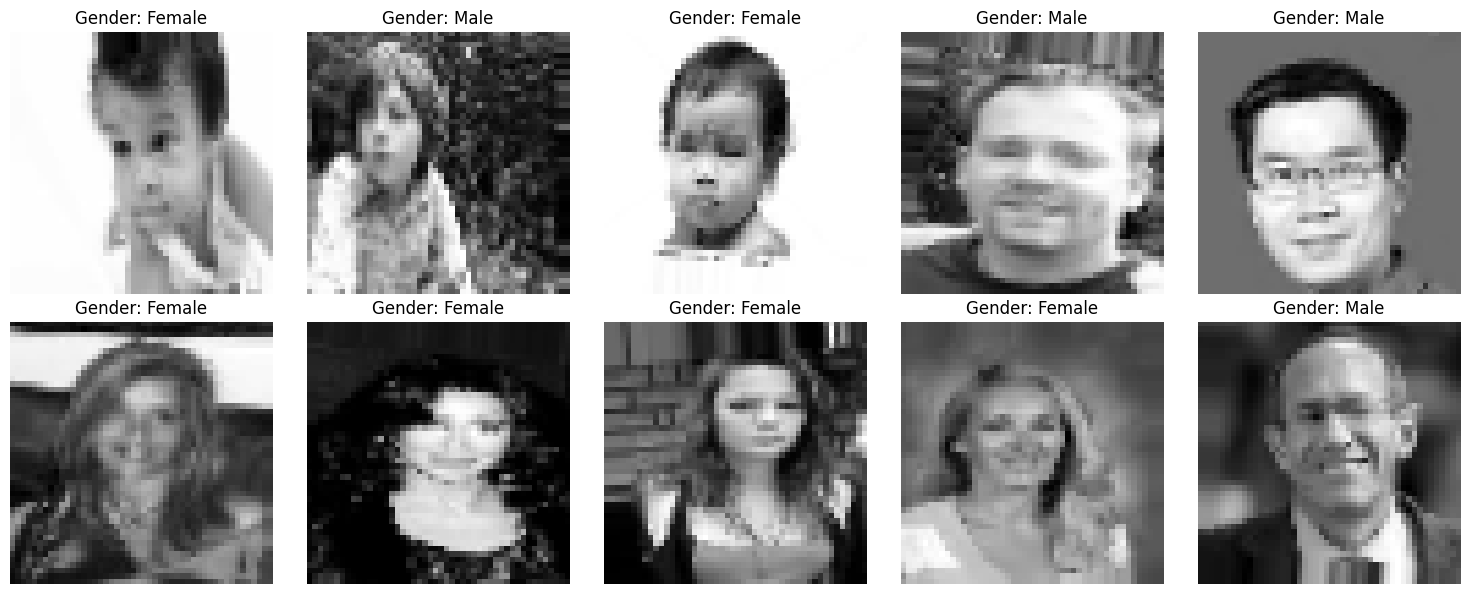


📈 Dataset distributions:
📊 Age distribution: 99 unique values
📊 Ethnicity distribution: 5 unique values
📊 Gender distribution: 2 unique values


In [9]:
# Tạo Data Generators để load ảnh trực tiếp
print("🔧 Đang tạo Data Generators...")

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Split data thành train/test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['gender'])
print(f"📊 Train set: {len(train_data)} samples")
print(f"📊 Test set: {len(test_data)} samples")

# Reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Custom data generator
class CustomImageGenerator:
    def __init__(self, dataframe, batch_size=32, target_size=(48, 48), shuffle=True, augment=False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        
        # Data augmentation
        if augment:
            self.datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                rescale=1./255
            )
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self._generate_batch(batch_indices)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _generate_batch(self, batch_indices):
        batch_x = np.zeros((len(batch_indices),) + self.target_size + (1,))
        batch_y = np.zeros(len(batch_indices))
        
        for i, idx in enumerate(batch_indices):
            # Load image
            img_path = self.dataframe.iloc[idx]['filepath']
            img = load_img(img_path, target_size=self.target_size, color_mode='grayscale')
            img_array = img_to_array(img)
            
            # Apply augmentation if needed
            if self.augment:
                img_array = self.datagen.random_transform(img_array)
            
            # Normalize
            img_array = img_array / 255.0
            batch_x[i] = img_array
            batch_y[i] = self.dataframe.iloc[idx]['gender']
        
        return batch_x, batch_y

# Tạo generators
train_generator = CustomImageGenerator(
    train_data, 
    batch_size=32, 
    shuffle=True, 
    augment=True  # Data augmentation cho train
)

test_generator = CustomImageGenerator(
    test_data, 
    batch_size=32, 
    shuffle=False, 
    augment=False  # Không augment cho test
)

print("✅ Data Generators đã được tạo!")
print(f"📊 Train generator: {len(train_generator)} batches")
print(f"📊 Test generator: {len(test_generator)} batches")

# Hiển thị một batch mẫu
print("\n🖼️ Hiển thị sample images từ generator:")
sample_x, sample_y = train_generator[0]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    if i < len(sample_x):
        row, col = i // 5, i % 5
        axes[row, col].imshow(sample_x[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f"Gender: {'Male' if sample_y[i]==0 else 'Female'}")
        axes[row, col].axis('off')
    else:
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()

print(f"\n📈 Dataset summary:")
print(f"📊 Age range: {data['age'].min()}-{data['age'].max()} years ({data['age'].nunique()} unique values)")
print(f"📊 Ethnicity categories: {data['ethnicity'].nunique()} unique values")
print(f"📊 Gender distribution: {data['gender'].value_counts().to_dict()}")
print("🎨 Distributions sẽ được tính toán ở cell tiếp theo cho visualization")


In [10]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 9707
Total columns: 5


## Distributions <a id="03"></a>

In [11]:
# Chuẩn bị dữ liệu cho visualization
print("📊 Chuẩn bị dữ liệu cho biểu đồ...")

# Tính toán distributions từ data (không cần pixels nữa)
age_dist = data['age'].value_counts().sort_index()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

print("✅ Đã tính toán distributions!")

# Cấu hình plotting
USE_PLOTLY = False  # Set to True nếu muốn dùng plotly, False để dùng matplotlib

# Hàm vẽ biểu đồ với fallback cho matplotlib
def ditribution_plot(x, y, name):
    """Vẽ biểu đồ phân phối với plotly hoặc matplotlib"""
    if USE_PLOTLY:
        try:
            fig = go.Figure([go.Bar(x=x, y=y)])
            fig.update_layout(title_text=name)
            fig.show()
        except:
            # Fallback to matplotlib if plotly fails
            plt.figure(figsize=(12, 6))
            plt.bar(x, y)
            plt.title(name)
            plt.xlabel('Categories')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    else:
        plt.figure(figsize=(12, 6))
        plt.bar(x, y)
        plt.title(name)
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Hàm vẽ biểu đồ training history
def line_plot(history_dict, title='Training History'):
    """Vẽ biểu đồ training history với plotly hoặc matplotlib"""
    if USE_PLOTLY:
        try:
            import plotly.express as px
            fig = px.line(
                history_dict, y=['loss', 'val_loss'],
                labels={'index': 'epoch', 'value': 'loss'},
                title=title)
            fig.show()
        except:
            # Fallback to matplotlib
            plt.figure(figsize=(12, 5))
            epochs = range(1, len(history_dict['loss']) + 1)
            plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
            plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
            plt.title(title)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        plt.figure(figsize=(12, 5))
        epochs = range(1, len(history_dict['loss']) + 1)
        plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

print("🎨 Functions sẵn sàng để vẽ biểu đồ!")

KeyError: 'pixels'

### Age Distribtion <a id="3.1"></a>

In [ ]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

NameError: name 'USE_PLOTLY' is not defined

### Ethnicity Distribution <a id="3.2"></a>

In [53]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

### Gender Distribution <a id="3.3"></a>

In [54]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [55]:
# ✅ KHÔNG CẦN CHUẨN BỊ X TỪ PIXELS NỮA
# Sử dụng Data Generators để load ảnh trực tiếp từ file
print("✅ Sử dụng Data Generators thay vì load pixels vào memory")
print("🎯 Ưu điểm: Tiết kiệm RAM, tải ảnh on-the-fly, data augmentation tự động")
print("📊 Data đã được chuẩn bị sẵn ở cell trước với:")
print(f"   - Train generator: {len(train_generator)} batches")
print(f"   - Test generator: {len(test_generator)} batches")

### Sample Images <a id="3.4"></a>

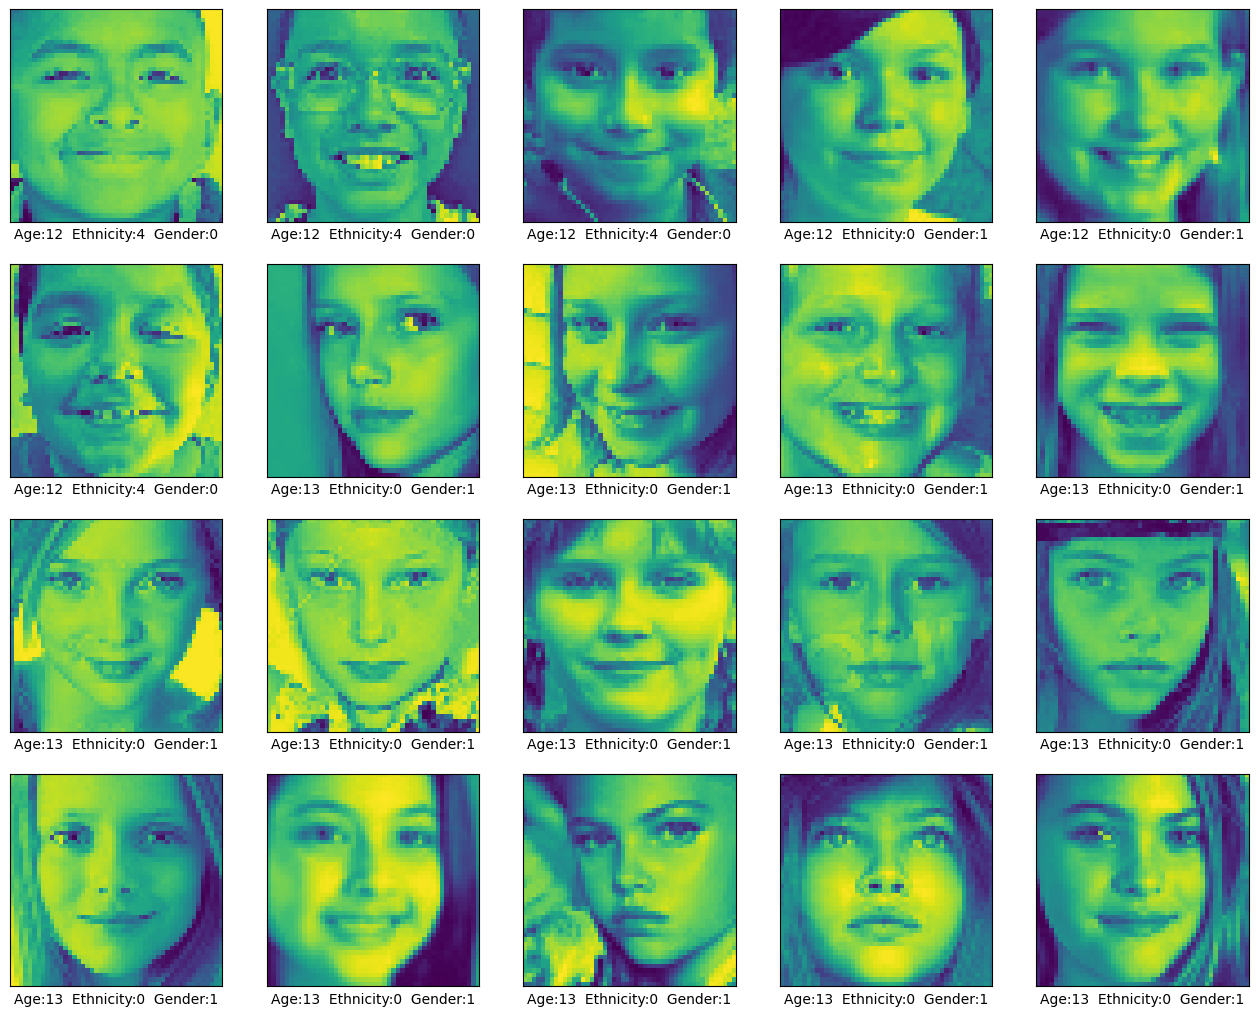

In [56]:
# Hiển thị sample images từ data generator
print("🖼️ Hiển thị sample images từ generator:")

# Lấy một batch từ train generator để hiển thị
sample_batch_x, sample_batch_y = train_generator[0]

plt.figure(figsize=(16,12))
for i in range(min(16, len(sample_batch_x))):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Hiển thị ảnh từ batch
    img = sample_batch_x[i].squeeze()  # Remove channel dimension for display
    plt.imshow(img, cmap='gray')
    
    # Get corresponding info from train_data
    row_idx = i  # First batch, so indices 0-31
    if row_idx < len(train_data):
        row = train_data.iloc[row_idx]
        plt.xlabel(
            f"Age:{row['age']} "
            f"Ethnicity:{row['ethnicity']} "
            f"Gender:{'M' if sample_batch_y[i]==0 else 'F'}"
        )
        
plt.tight_layout()
plt.show()

print(f"✅ Đã hiển thị {min(16, len(sample_batch_x))} hình ảnh mẫu từ generator")
print("🎯 Lưu ý: Ảnh được load trực tiếp từ file, không qua memory buffer")

 <a id="04"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Gender Prediction</center>
</h1>

### Split data into train/test <a id="4.1"></a>

In [57]:
# ✅ SKIP - Data đã được split ở cell trước
# Sử dụng train_generator và test_generator có sẵn
print("✅ Sử dụng generators có sẵn:")
print(f"📊 Train generator: {len(train_generator)} batches ({len(train_data)} samples)")
print(f"📊 Test generator: {len(test_generator)} batches ({len(test_data)} samples)")
print("🎯 Tỷ lệ train/test: 80/20")

### Build and train model <a id="4.2"></a>

In [58]:
# Xây dựng CNN model cho Gender Prediction
print("🏗️ Đang xây dựng model cho Gender Prediction...")

model = tf.keras.Sequential([
    L.Input(shape=(48, 48, 1)),  # Sửa input layer
    
    # First conv block
    L.Conv2D(32, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Second conv block  
    L.Conv2D(64, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Third conv block
    L.Conv2D(128, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Dense layers
    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.5),
    L.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model với optimizer tốt hơn
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Model đã được xây dựng thành công!")

# Callbacks tốt hơn
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

# Model checkpoint để lưu model tốt nhất
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_gender_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

# Model summary
model.summary()

print(f"\n📊 Model info:")
print(f"   - Input shape: (48, 48, 1)")
print(f"   - Total parameters: {model.count_params():,}")
print(f"   - Output: Binary classification (0=Male, 1=Female)")
print(f"   - Optimizer: Adam")
print(f"   - Callbacks: Early Stopping, LR Reduction, Model Checkpoint")

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,673 (1.64 MB)

 Trainable params: 428,609 (1.64 MB)

 Non-trainable params: 64 (256.00 B)

In [59]:
# Train model với Data Generators
print("🚀 Bắt đầu training model với generators...")
print(f"📊 Training batches: {len(train_generator)}")
print(f"📊 Validation batches: {len(test_generator)}")

history = model.fit(
    train_generator,  # Sử dụng train generator
    epochs=30,  # Số epochs phù hợp
    validation_data=test_generator,  # Sử dụng test generator cho validation
    callbacks=callbacks,  # Sử dụng callbacks
    verbose=1
)

print("✅ Training hoàn thành!")
print(f"📈 Epoch đã train: {len(history.history['loss'])}")
print(f"🎯 Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print("💾 Model tốt nhất đã được lưu tại: best_gender_model.h5")

Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5230 - loss: 0.6915 - val_accuracy: 0.5268 - val_loss: 0.6915
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5231 - loss: 0.6894 - val_accuracy: 0.5268 - val_loss: 0.6902
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5327 - loss: 0.6877 - val_accuracy: 0.5322 - val_loss: 0.6869
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5548 - loss: 0.6852 - val_accuracy: 0.5430 - val_loss: 0.6825
Epoch 5/20
  7/260 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5685 - loss: 0.6766

KeyboardInterrupt: 

### Evaluate training history <a id="4.3"></a>

In [ ]:
line_plot(history.history, 'Gender Prediction - Training History')

In [ ]:
# Evaluate model với test generator
print("📊 Đang đánh giá model...")
loss, acc = model.evaluate(test_generator, verbose=0)
print('✅ Test loss: {:.4f}'.format(loss))
print('✅ Test Accuracy: {:.4f}'.format(acc))

# Thống kê chi tiết
print(f"\n📈 Kết quả chi tiết:")
print(f"🎯 Độ chính xác: {acc*100:.2f}%")
print(f"📉 Loss: {loss:.4f}")
print(f"📊 Số samples đánh giá: {len(test_data)}")
print(f"🎲 Random baseline: ~50% (binary classification)")

<a id="05"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Ethnicity Prediction</center>
</h1>

### Split data into train/test <a id="5.1"></a>

In [ ]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="5.2"></a>

In [ ]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

In [ ]:
history = model.fit(
    X_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback]
)

### Evaluate training history <a id="5.3"></a>

In [ ]:
line_plot(history.history, 'Ethnicity Prediction - Training History')

In [ ]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

<a id="06"></a>

<h1 class="list-group-item active" style='background:orange; border:0'>
    <center>Model for Age prediction</center>
</h1>

### Split data into train/test <a id="6.1"></a>

In [ ]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="6.2"></a>

In [ ]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

In [ ]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

### Evaluate training history <a id="6.3"></a>

In [ ]:
line_plot(history.history, 'Age Prediction - Training History')

In [ ]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

![Alt Text](https://www.kudos.com/assets/Blog/b5843aa89b/thankyou__FillWzcwMCw0NDBd.jpg)